# BUTTER-E Dataset - Quality Control

This notebook reads the output of 2_join.ipynb and performes quality control by adding filtering columns or data that had errors during data collection.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import urllib.request as r
import ssl
import json
from multiprocess import Pool
from tqdm import *
import matplotlib.pyplot as plt
from IPython.display import Image

/home/ctripp/gcomp/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

In [3]:
# Read the data
butter_e = pd.read_csv("data_artifacts/butter_e_metadata_join_energy.csv")
error = pd.read_csv("data_artifacts/butter_e_metadata_join_energy_error.csv")

# Fix the dtypes that are not properly imported by Pandas
butter_e["start_time"] = pd.to_datetime(butter_e["start_time"])
butter_e["update_time"] = pd.to_datetime(butter_e["update_time"])
butter_e["run_time"] = (
    butter_e["update_time"] - butter_e["start_time"]
).dt.total_seconds()

print("Total number of runs:", len(butter_e))

Total number of runs: 40464


## Apply Filters to the Data

The following filters are applied to the data:
1. **Filter 1**: Remove runs that have a run time greater than 75000 seconds.
2. **Filter 2**: Remove runs that have zero energy usage
3. **Filter 3**: Remove runs that are more than 4 standard deviations from the mean of the run time in log space


In [4]:
# Filter 1 - Long runtimes
butter_e["filter_1"] = butter_e["run_time"] > 75000

# Filter 2 - Zero energy
butter_e["filter_2"] = butter_e["energy"] == 0

# Filter 3 - Within 4 standard deviations of runtime in log space
stdevs = butter_e.groupby(["is_gpu", "dataset", "size"])["run_time"].transform(
    lambda x: (
        np.abs(np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
        if len(x) > 1
        else np.nan
    )
)
butter_e["filter_3"] = (
    stdevs > 4
)  # instead of using stdev, try some number of iqr or normalized median value
butter_e["filter_3_stdevs"] = stdevs

## Check how many runs are removed by each filter

In [5]:
so_far = butter_e["filter_1"]
cum_filtered = 0
for filter in ["filter_1", "filter_2", "filter_3"]:
    so_far = so_far | butter_e[filter]
    print(
        f"{filter} matches {butter_e[filter].sum()} entries, which is {so_far.sum() - cum_filtered} more"
    )
    cum_filtered = so_far.sum()

butter_e["filter"] = butter_e["filter_1"] | butter_e["filter_2"] | butter_e["filter_3"]
matching_runs = butter_e["filter"].sum()
total_runs = len(butter_e["run_id"].unique())
print(
    f"The filters reject {matching_runs} runs in total, or  {matching_runs / total_runs * 100} % of the data"
)


# Write out the data
butter_e.to_csv("data_artifacts/runs_with_energy.csv", index=False)

filter_1 matches 163 entries, which is 163 more
filter_2 matches 0 entries, which is 0 more
filter_3 matches 240 entries, which is 78 more
The filters reject 241 runs in total, or  0.5955911427441676 % of the data


## Generate Filtering Figures for Paper

In the following cells, the filters are explored amd figures for the paper are generated.

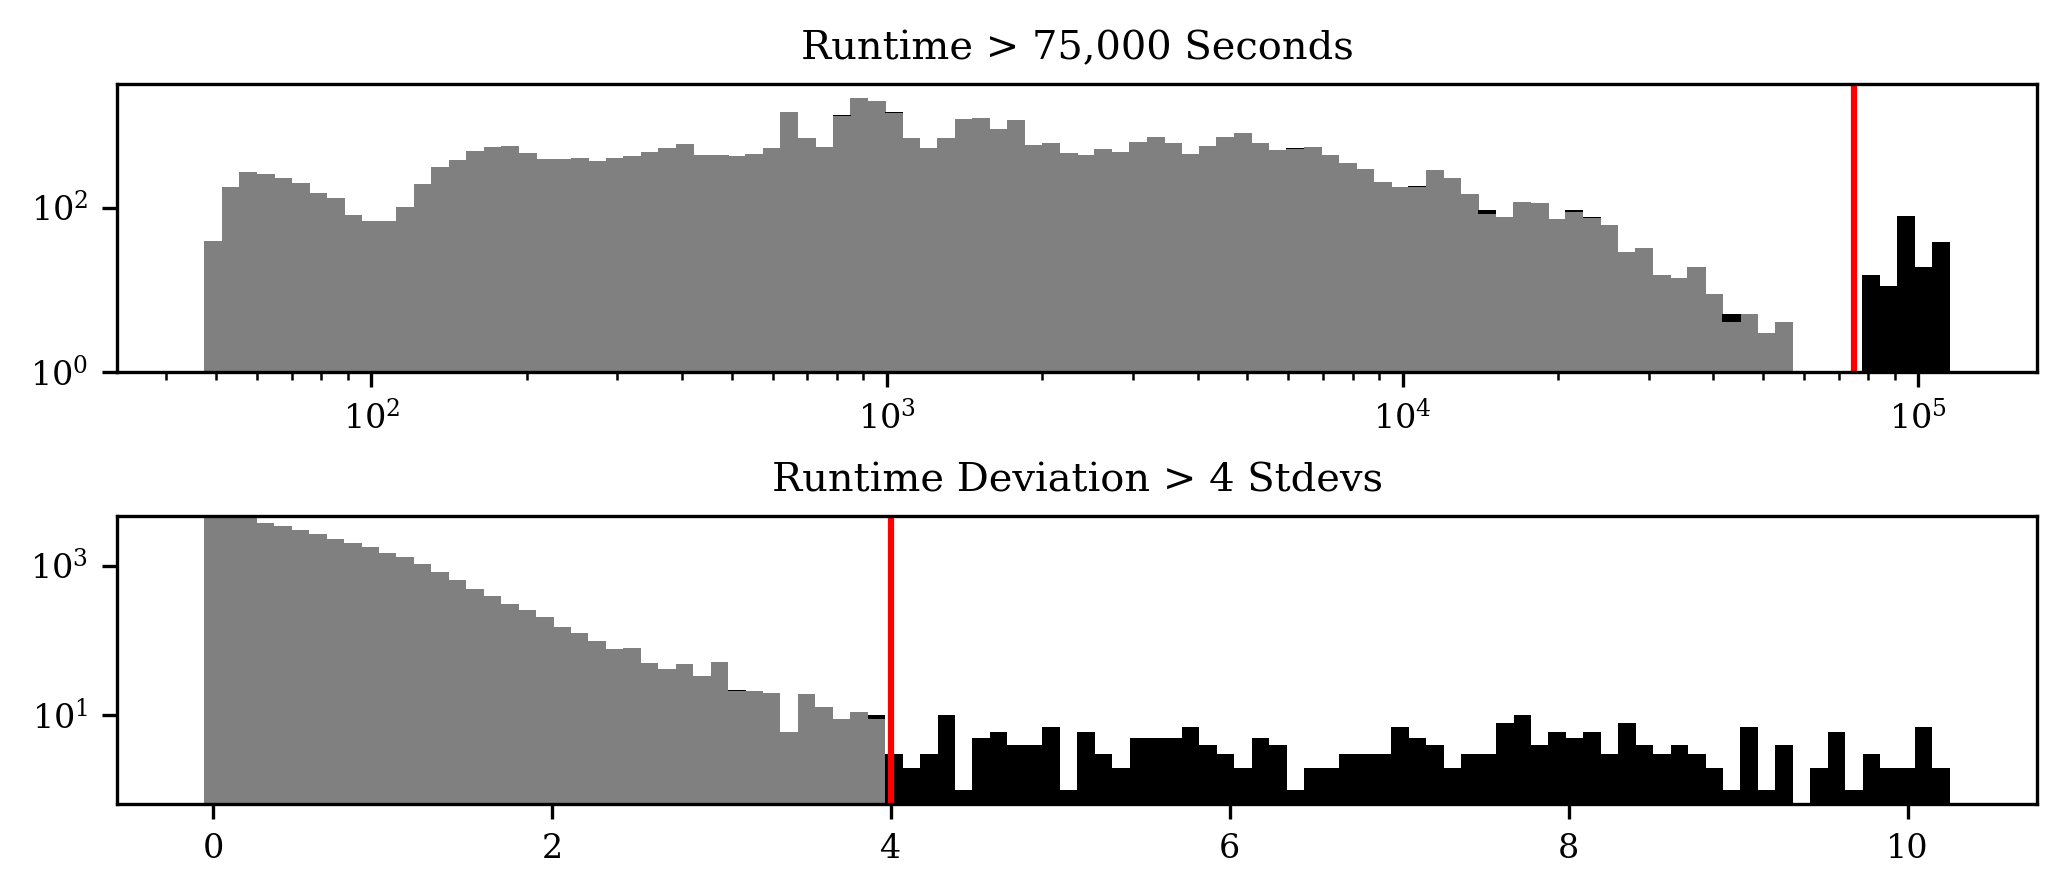

In [6]:
# Single figure
selection = butter_e


fig = plt.figure(figsize=(8, 3), dpi=300)
gs = fig.add_gridspec(
    2, 1, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.5
)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])


## Runtime Filter Histogram
plt.sca(ax1)

good_data = np.histogram(
    np.log10(selection.query("filter==False")["run_time"]),
    bins=100,
    range=(
        np.log10(selection["run_time"]).min(),
        np.log10(selection["run_time"]).max(),
    ),
)
bad_data = np.histogram(
    np.log10(selection.query("filter==True")["run_time"]),
    bins=100,
    range=(
        np.log10(selection["run_time"]).min(),
        np.log10(selection["run_time"]).max(),
    ),
)
plt.bar(
    10 ** good_data[1][:-1],
    good_data[0],
    width=np.diff(10 ** good_data[1]),
    label="Retained",
    color="gray",
)
plt.bar(
    10 ** bad_data[1][:-1],
    bad_data[0],
    width=np.diff(10 ** bad_data[1]),
    bottom=good_data[0],
    label="Removed",
    color="black",
)
plt.axvline(75000, color="red")
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_title("Runtime > 75,000 Seconds")


## Standard deviation filter Histogram
plt.sca(ax2)

good_data = np.histogram(
    selection.query("filter==False")["filter_3_stdevs"],
    bins=100,
    range=(selection["filter_3_stdevs"].min(), selection["filter_3_stdevs"].max()),
)
bad_data = np.histogram(
    selection.query("filter==True")["filter_3_stdevs"],
    bins=100,
    range=(selection["filter_3_stdevs"].min(), selection["filter_3_stdevs"].max()),
)
plt.bar(
    good_data[1][:-1],
    good_data[0],
    width=np.diff(good_data[1]),
    label="Retained",
    color="gray",
)
plt.bar(
    bad_data[1][:-1],
    bad_data[0],
    width=np.diff(bad_data[1]),
    bottom=good_data[0],
    label="Removed",
    color="black",
)
plt.axvline(4, color="red")

# ax2.set_xscale("log")
ax2.set_yscale("log")
# ax2.set_xlim(0.5, 12)


ax2.set_title("Runtime Deviation > 4 Stdevs")

plt.savefig("figures/3_qc_combined_histograms.svg", dpi=600, bbox_inches="tight")
plt.savefig("figures/3_qc_combined_histograms.png", dpi=600, bbox_inches="tight")

# Legacy figures that were used for data exploration

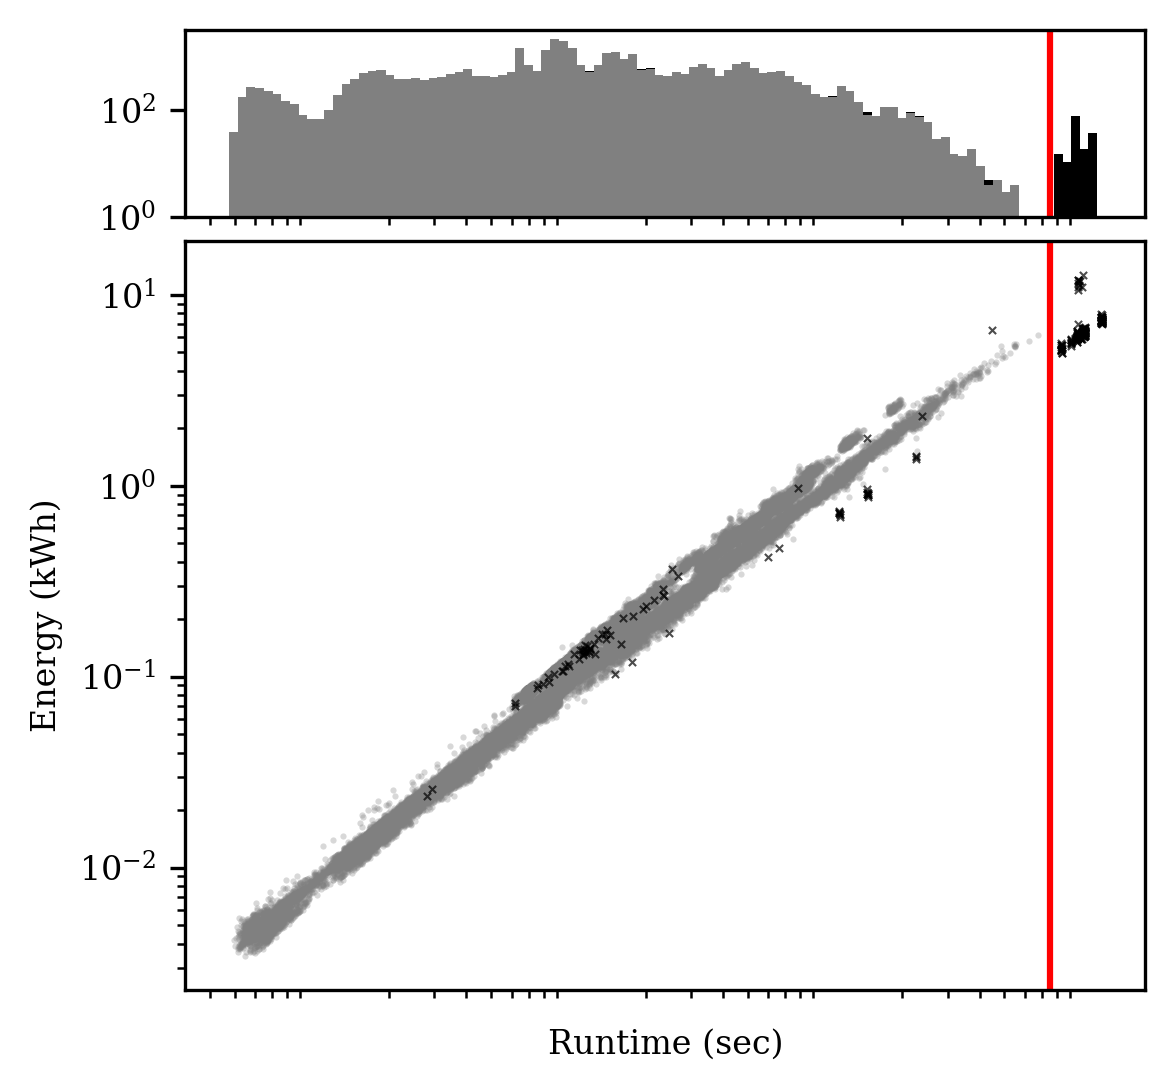

In [7]:
selection = butter_e

# Figure and Axes
fig = plt.figure(figsize=(8 / 2, 8 / 2), dpi=300)
gs = fig.add_gridspec(
    2,
    1,
    height_ratios=(1, 4),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
ax = fig.add_subplot(gs[1])
ax_histx = fig.add_subplot(gs[0], sharex=ax)


plt.sca(ax)

plt.scatter(
    x=selection.query("filter==False")["run_time"],
    y=selection.query("filter==False")["energy"],
    marker=".",
    s=1,
    alpha=0.3,
    color="gray",
)

plt.scatter(
    x=selection.query("filter==True")["run_time"],
    y=selection.query("filter==True")["energy"],
    marker="x",
    alpha=0.7,
    s=3,
    linewidths=0.5,
    color="black",
)

plt.axvline(75000, color="red")

plt.yscale("log")
plt.xscale("log")
plt.ylabel("Energy (kWh)")
plt.xlabel("Runtime (sec)")

### X axis marginal
plt.sca(ax_histx)

good_data = np.histogram(
    np.log10(selection.query("filter==False")["run_time"]),
    bins=100,
    range=(
        np.log10(selection["run_time"]).min(),
        np.log10(selection["run_time"]).max(),
    ),
)
bad_data = np.histogram(
    np.log10(selection.query("filter==True")["run_time"]),
    bins=100,
    range=(
        np.log10(selection["run_time"]).min(),
        np.log10(selection["run_time"]).max(),
    ),
)
plt.bar(
    10 ** good_data[1][:-1],
    good_data[0],
    width=np.diff(10 ** good_data[1]),
    label="Retained",
    color="gray",
)
plt.bar(
    10 ** bad_data[1][:-1],
    bad_data[0],
    width=np.diff(10 ** bad_data[1]),
    bottom=good_data[0],
    label="Removed",
    color="black",
)
ax_histx.set_yticks([])
plt.axvline(75000, color="red")
ax_histx.set_xticks([])
ax_histx.set_yscale("log")

plt.savefig("figures/3_qc_runtime_energy_scatterplot.png", dpi=600, bbox_inches="tight")

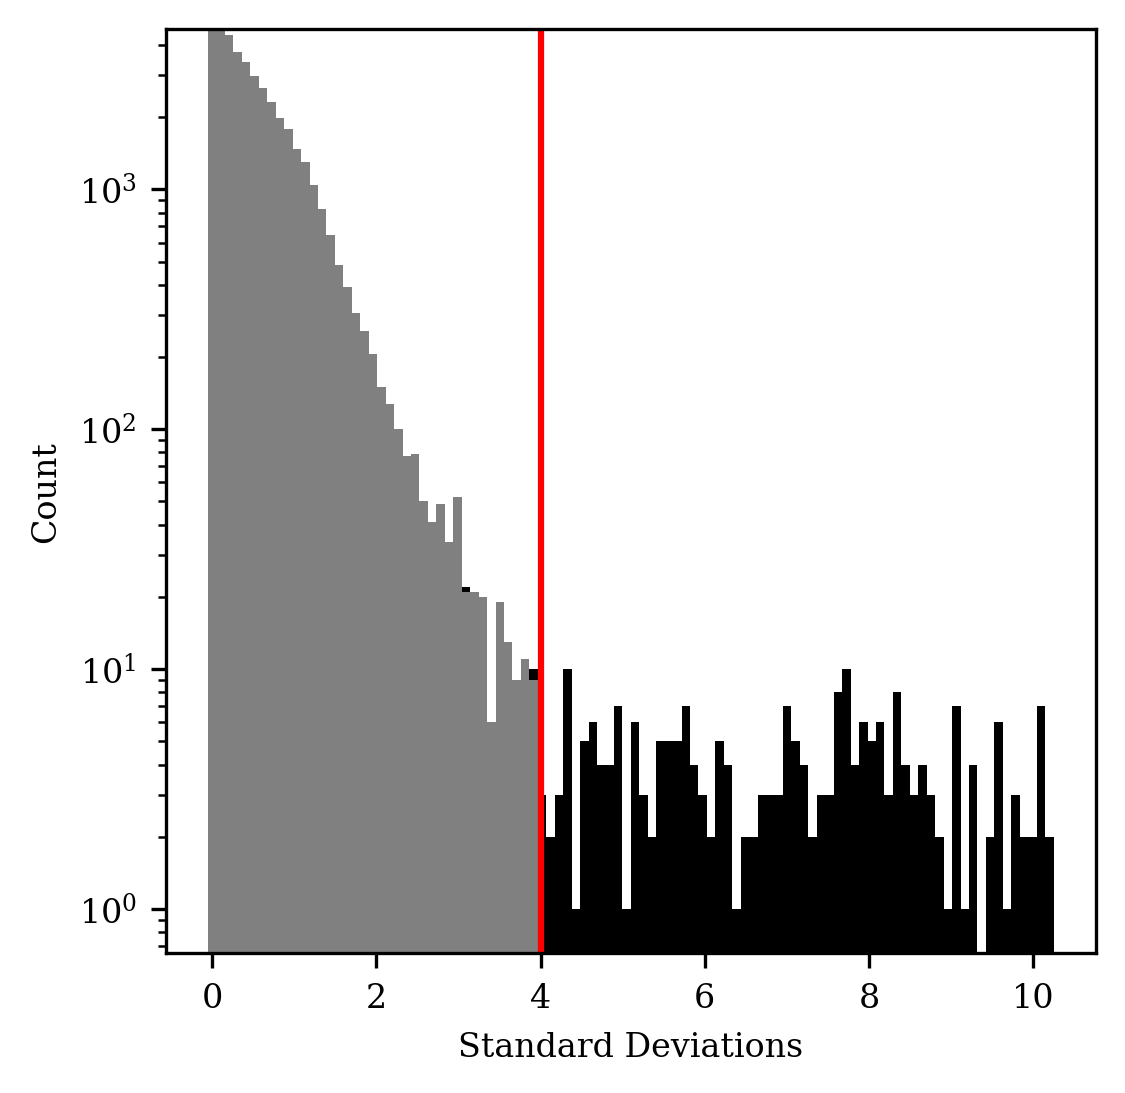

In [8]:
# Histograms: run time showing > 90000, energy showing == 0, runtime vs energy showing 9/29, depths showing optimizer_energy_1_cpu

plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

selection = butter_e  # .query("filter_4!=True")

# Create a Figure, which doesn't have to be square.
fig = plt.figure(figsize=(8 / 2, 8 / 2), dpi=300)

good_data = np.histogram(
    selection.query("filter==False")["filter_3_stdevs"],
    bins=100,
    range=(selection["filter_3_stdevs"].min(), selection["filter_3_stdevs"].max()),
)
bad_data = np.histogram(
    selection.query("filter==True")["filter_3_stdevs"],
    bins=100,
    range=(selection["filter_3_stdevs"].min(), selection["filter_3_stdevs"].max()),
)
plt.bar(
    good_data[1][:-1],
    good_data[0],
    width=np.diff(good_data[1]),
    label="Retained",
    color="gray",
)
plt.bar(
    bad_data[1][:-1],
    bad_data[0],
    width=np.diff(bad_data[1]),
    bottom=good_data[0],
    label="Removed",
    color="black",
)
ax_histx.set_yticks([])
plt.axvline(4, color="red")
ax_histx.set_xticks([])

# plt.xscale("log")
plt.yscale("log")


plt.xlabel("Standard Deviations")
plt.ylabel("Count")

plt.savefig("figures/3_qc_stdev_filter_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

<!-- ### Other Figures

These figures may not have made it into the paper, but were helpful in designing the filters.

# px.scatter(butter_e, x="size", y="run_time", facet_col="is_gpu", facet_row="dataset", color="filter_3", log_x=True, log_y=True, height=500*13, width=1000, hover_data=['depth', 'filter_3_stdevs']) -->